

You can download the dataset from [here](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge).



**Import the libraries**

First, import all the necessary libraries into our notebook. LibROSA, sounddevice and SciPy are the Python libraries used for processing audio signals.

In [2]:
pip install librosa

  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320724 sha256=54c090a894a42c04f063f91cf12f7a303e66fc71173d1f9415d2f5b75709e432
  Stored in directory: c:\users\kpurn\appdata\local\pip\cache\wheels\6f\d1\5d\f13da53b1dcbc2624ff548456c9ffb526c914f53c12c318bb4
  Created wheel for audioread: filename=audioread-2.1.9-py3-none-any.whl size=23146 sha256=13f66bb42f12697d047ff55c52a9e2cd7d784045ce726e41eb01120ec0e37c1c
  Stored in directory: c:\users\kpurn\appdata\local\pip\cache\wheels\49\5a\e4\df590783499a992a88de6c0898991d1167453a3196d0d1eeb7
Successfully built resampy audioread
Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install sounddevice

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

warnings.filterwarnings("ignore")

C:\Users\kpurn\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\kpurn\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\kpurn\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
pwd

'C:\\Users\\kpurn\\OneDrive - University of Missouri\\tensorflow-speech-recognition-challenge'

**Data Exploration and Visualization**

Data Exploration and Visualization helps us to understand the data as well as pre-processing steps in a better way. 

**Visualization of Audio signal in time series domain**

Now, we’ll visualize the audio signal in the time series domain:

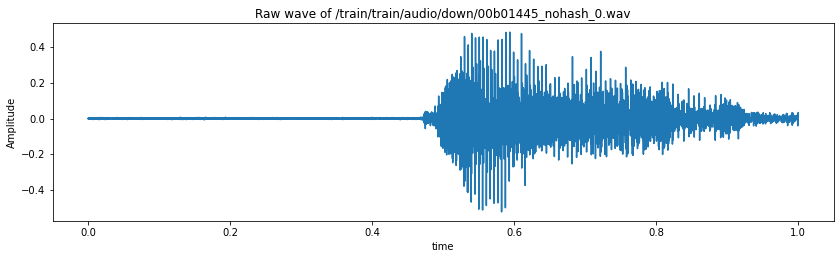

In [3]:
train_audio = './train/train/audio/'
samples, sample_rate = librosa.load(train_audio+'down/00b01445_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '/train/train/audio/down/00b01445_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

**Sampling rate **

Sampling rate or sampling frequency defines the number of samples per second (or per other unit) taken from a continuous signal to make a discrete or digital signal. Let us look into the sampling rate

In [4]:
ipd.Audio(samples, rate=sample_rate)

In [5]:
print(sample_rate)

16000


**Resampling**

The Sampling rate of the signal is found to be 16000, Most of the hearning frequency is around 8000 Hz, we will reduce the frequency to 8000Hz.

In [6]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

Now, let’s understand the number of recordings for each voice command:
In our dataset, we have some voice commands that represent each command. we will take a look into what all voices are present in the dataset

In [7]:
labels=os.listdir(train_audio)

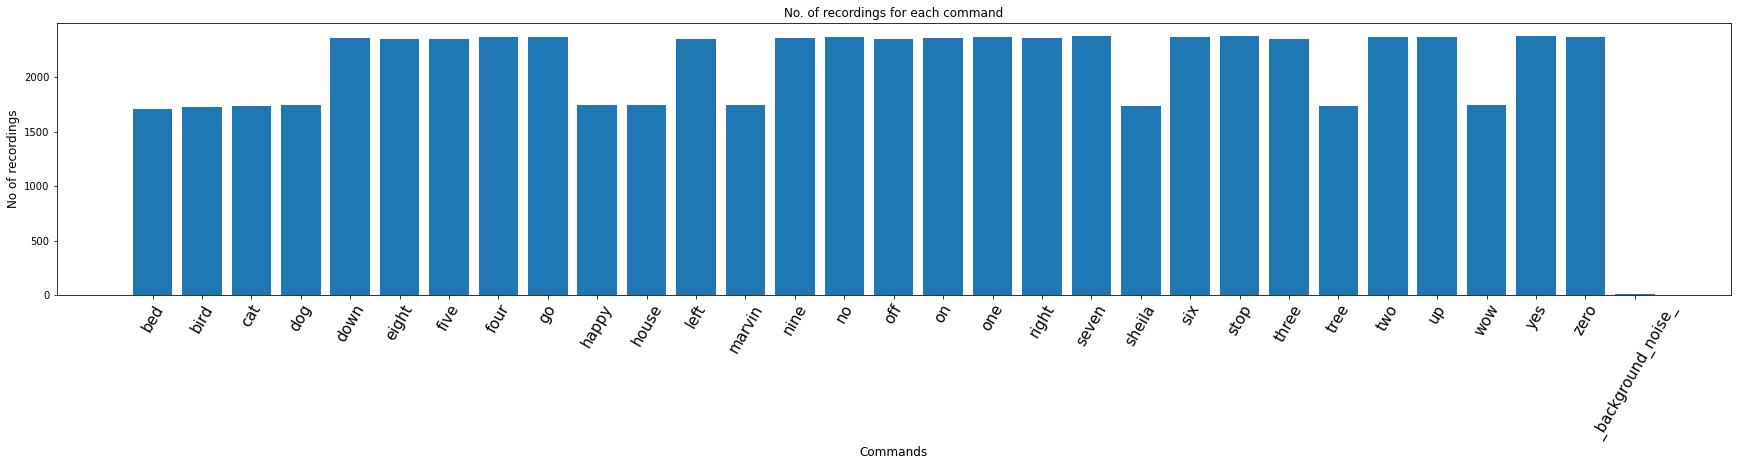

In [8]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [9]:
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

**Duration of recordings**

What’s next? A look at the distribution of the duration of recordings:

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <BarContainer object of 10 artists>)

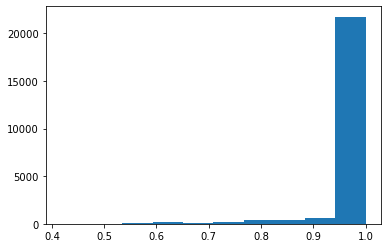

In [10]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

**Preprocessing the audio waves**

We saw previously in the data exploration section that the duration of a few recordings is less than 1 second and the sampling rate is too high. So, let's read the audio waves and utilize the preprocessing methods listed below to cope with this.

Here are the two steps we’ll follow:

* Resampling
* Removing shorter commands of less than 1 second

Let us define these preprocessing steps in the below code snippet:

In [11]:
train_audio_path = './train/train/audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


As the outputs are in text format, it is beter to convert them to labels. So, we use label encoder to change the text into labels

In [12]:

le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

Now, convert the integer encoded labels to a one-hot vector since it is a multi-classification problem:

In [13]:

y=np_utils.to_categorical(y, num_classes=len(labels))

Reshape the 2D array to 3D since the input to the conv1d must be a 3D array:

In [14]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

**Split into train and validation set**

Next, we will train the model on 80% of the data and validate on the remaining 20%:


In [15]:

x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

**Model Architecture for this problem**

Our speech-to-text model is created using Conv1D. Conv1D is a convolution neural network that does convolution along one dimension

**Model building**

Let us implement the model using Keras functional API.

In [16]:

K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,16, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 16, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 32, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 64, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7985, 8)           136       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2661, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2661, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2646, 16)          2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 882, 16)          0         
 1D)                                                         

Define the loss function to be categorical cross-entropy since it is a multi-classification problem:

In [17]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and to save the best model after every epoch:

In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

Let us train the model on a batch size of 32 and evaluate the performance on the holdout set:

In [19]:
history=model.fit(x_tr, y_tr ,epochs=10, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/10
533/533 [==============================] - 83s 154ms/step - loss: 1.8791 - accuracy: 0.2873 - val_loss: 1.3845 - val_accuracy: 0.4987
Epoch 2/10
533/533 [==============================] - 89s 166ms/step - loss: 1.2408 - accuracy: 0.5497 - val_loss: 1.0027 - val_accuracy: 0.6570
Epoch 3/10
533/533 [==============================] - 90s 168ms/step - loss: 0.9872 - accuracy: 0.6588 - val_loss: 0.7952 - val_accuracy: 0.7279
Epoch 4/10
533/533 [==============================] - 89s 168ms/step - loss: 0.8128 - accuracy: 0.7257 - val_loss: 0.6916 - val_accuracy: 0.7635
Epoch 5/10
533/533 [==============================] - 89s 167ms/step - loss: 0.7015 - accuracy: 0.7657 - val_loss: 0.5649 - val_accuracy: 0.8074
Epoch 6/10
533/533 [==============================] - 90s 168ms/step - loss: 0.6345 - accuracy: 0.7866 - val_loss: 0.5888 - val_accuracy: 0.8006
Epoch 7/10
533/533 [==============================] - 89s 166ms/step - loss: 0.5858 - accuracy: 0.8041 - val_loss: 0.5183 - val_ac

**Diagnostic plot**

I’m going to lean on visualization again to understand the performance of the model over a period of time:

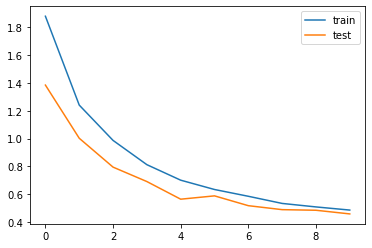

In [21]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Loading the best model**

Define the function that predicts text for the given audio:

In [23]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

Prediction time! Make predictions on the validation data:

In [24]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: down


In [25]:
print("Text:",predict(samples))

Text: down


The best part is yet to come! Here is a script that prompts a user to record voice commands. Record your own voice commands and test it on the model:

In [26]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


Let us now read the saved voice command and convert it to text:

In [36]:
filepath='./test/test/audio/clip_00ad78827.wav'

In [37]:
#reading the voice commands
samples, sample_rate = librosa.load(filepath , sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)              

In [38]:
#converting voice commands to text
predict(samples)

'left'